# DSCI Group Project -- Group 42

## Research Question

In [19]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(themis)

set.seed(6666)

players <- read_csv("players.csv")


clean_players <- players |>
    mutate(subscribe = as.factor(subscribe),
           experience = as.factor(experience)) |>
    select(-hashedEmail, -gender, -name) |>
    filter(!is.na(Age)) |>
    filter(!is.na(experience)) |>
    filter(!is.na(subscribe))


clean_players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17
Regular,TRUE,0.0,19
Amateur,FALSE,0.0,21
Amateur,TRUE,0.1,47


## Setting Up Training and Testing Data

In [20]:
players_split <- initial_split(clean_players, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

## Creating a Recipe and Model

In [27]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE)

knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

## Using 5 Fold Cross Validation and Train the Model

In [28]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 103, by = 1))

knn_tuned_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tuned) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

## Visualize Accuracy with Different K Values

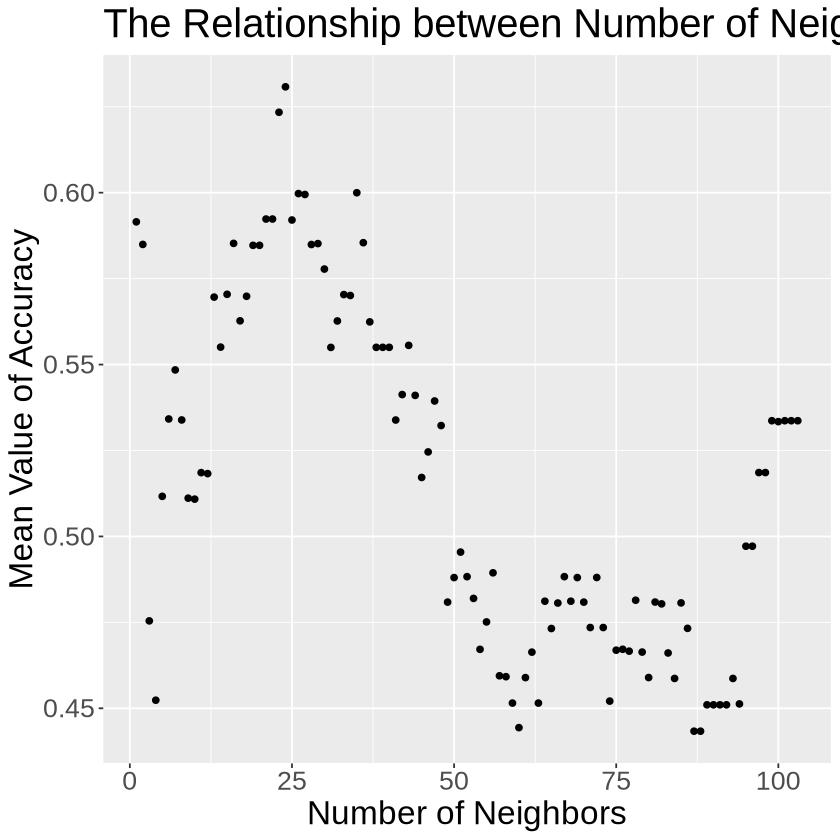

In [29]:
accuracy <- knn_tuned_fit |>
    filter(.metric == "accuracy")
accuracy_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Number of Neighbors",
         y = "Mean Value of Accuracy") +
    ggtitle("The Relationship between Number of Neighbors (k) and Their Mean Value") +
    theme(text = element_text(size = 20))
accuracy_plot

## Find the Best K and Fitting it in Training Data

In [43]:
best_k <- accuracy |>
    slice_max(mean) |>
    pull(neighbors)
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_best) |>
    fit(players_test)


## Predict Using Testing Data

In [44]:
subscribe_predictions <- predict(knn_best_fit, players_test) |>
    bind_cols(players_test)
subscribe_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
subscribe_metrics
subscribe_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5254237
kap,binary,0.1377871


.pred_class,experience,subscribe,played_hours,Age
<fct>,<fct>,<fct>,<dbl>,<dbl>
TRUE,Veteran,FALSE,0.0,17
FALSE,Amateur,FALSE,0.0,21
FALSE,Pro,TRUE,0.0,17
FALSE,Amateur,TRUE,0.2,22
TRUE,Veteran,TRUE,0.0,17
FALSE,Regular,TRUE,0.3,58
FALSE,Amateur,FALSE,0.1,17
TRUE,Beginner,TRUE,0.0,17
FALSE,Amateur,TRUE,1.8,23
